In [11]:
import nbsetup
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ergodicpy as ep
import scipy as sp

SAVE_FIGURES = False
x_points = 50

In [12]:
def compare(x_range, hue_range, hist_func, hue_label, name=None, power=1.0, boost=2000):
    data = []
    for hue in hue_range:
        for x in x_range:
            hists = hist_func(x, hue)
            
            # analyse
            complexity = ep.measures(hists)['complexity']
            chi2, p, _, _ = sp.stats.chi2_contingency(hists)
            states = len(hists[0])
            
            # 2000 boost, 1.0 power
            # 2000 boost, 1.2 power (states compensate ish)
            # 300 boost, 2.0 power (doesn't really fit)
            # power=0.0, boost=200000 (not great - as too tight for small state numbers)
            
            #cex = complexity*states*100
            #cep = 1 - sp.stats.chi2.cdf(cex, states)
            tau2 = (complexity**2)*(states**power)*boost
            tau2_p = 1 - sp.stats.chi2.cdf(tau2, states)
            #tau2, tau2_p = ep.tau2(complexity, states, power, boost)
            
            # store
            data.append({
                'chi2': chi2,
                'chi2_p': p,
                'tau2': tau2,
                'tau2_p': tau2_p,
                'x': x,
                hue_label : hue,
            })
    
    fig = plot(data, hue=hue_label)
    if SAVE_FIGURES and name is not None:
        fig.savefig("figures/%s.eps" % name)

def plot(data, x='x', hue='hue'):
    d = data[0].copy()
    del d[x]
    del d[hue]
    
    fig, axes = plt.subplots(2, 2, sharex=True, figsize=(10,10))
    df = pd.DataFrame(data)
    # chi2
    g = sns.lineplot(data=df, x=x, y='chi2', ax=axes[0][0], hue=hue)
    g.set(title='Chi2', ylabel=None)
    
    g = sns.lineplot(data=df, x=x, y='chi2_p', ax=axes[0][1], hue=hue, legend=False)
    axes[0][1].axhline(y=0.05, color='grey', linestyle='dotted')
    g.set(ylim=(-0.05,1.05), title='Chi2 p-value', ylabel=None)
    
    # ce
    #g = sns.lineplot(data=df, x=x, y='cex', ax=axes[1][0], hue=hue, legend=False)
    #g.set(title='Ergodic Complexity * states (Ce*b)', ylabel=None)
    
    #g = sns.lineplot(data=df, x=x, y='cep', ax=axes[1][1], hue=hue, legend=False)
    #axes[1][1].axhline(y=0.05, color='grey', linestyle='dotted')
    #g.set(ylim=(-0.05,1.05), title='Ergodic Complexity * states p-value', ylabel=None)
    
    # ce
    g = sns.lineplot(data=df, x=x, y='tau2', ax=axes[1][0], hue=hue, legend=False)
    g.set(title='Tau2', ylabel=None)
    
    g = sns.lineplot(data=df, x=x, y='tau2_p', ax=axes[1][1], hue=hue, legend=False)
    axes[1][1].axhline(y=0.05, color='grey', linestyle='dotted')
    g.set(ylim=(-0.05,1.05), title='Tau2 p-value', ylabel=None)
    
    return fig

# Observations count

- C is invariant to the number of observations
- While for _p_ the fewer the observations, the less confident it is about being heterogenious 

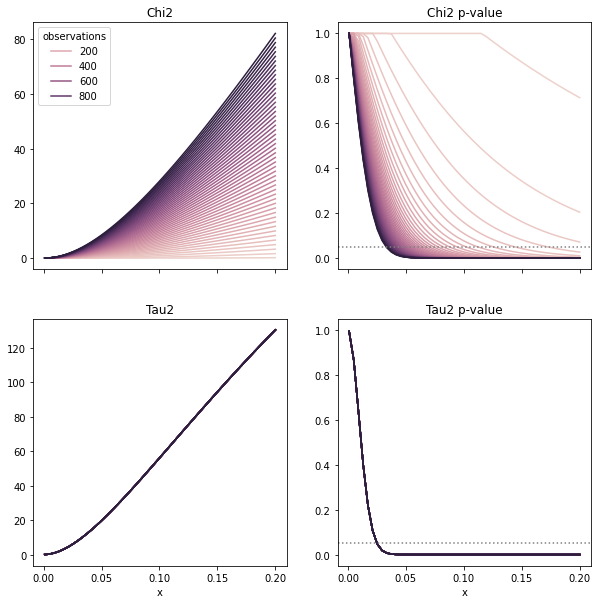

In [144]:
compare(np.linspace(0.001,0.2,x_points), range(10,1000,20), lambda x, h: np.array([[0.1,1],[0.1+x,1]])*h, 'observations')

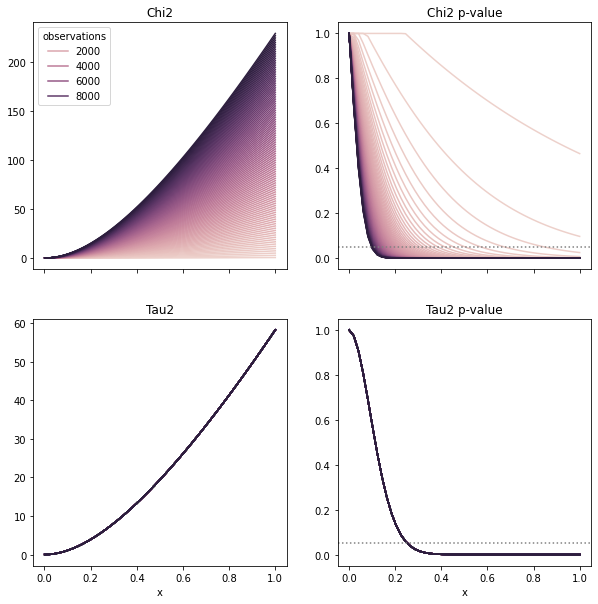

In [145]:
compare(np.linspace(0.001,1.0,x_points), range(50,10000,100), lambda x, h: np.array([[0.1,1],[0.1,1+x]])*h, 'observations')

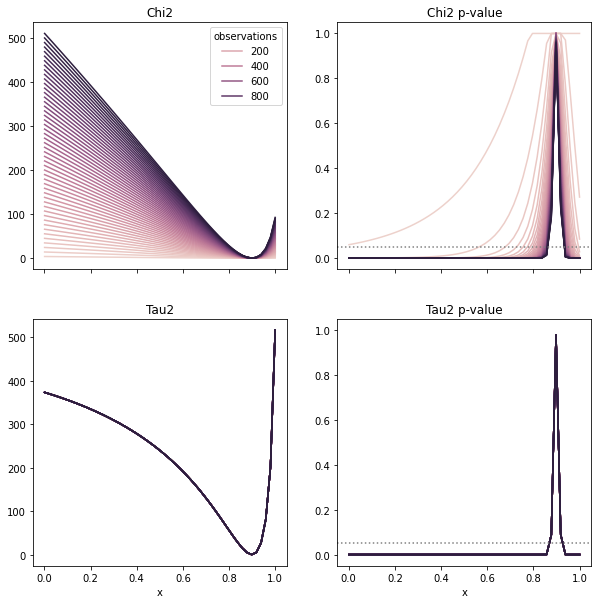

In [146]:
compare(np.linspace(0.001,1.0,x_points), range(10,1000,20), lambda x, h: np.array([[0.1,1],[1-x,1]])*h, 'observations')

# Ensembles

- C is largely invariant to the number of ensembles
- Chi2 heavily depends on it, as it fits into it's degrees of freedom
- But _p_ crosses at the 0.1 threshold at the same point, as it's interrepted in a similar way

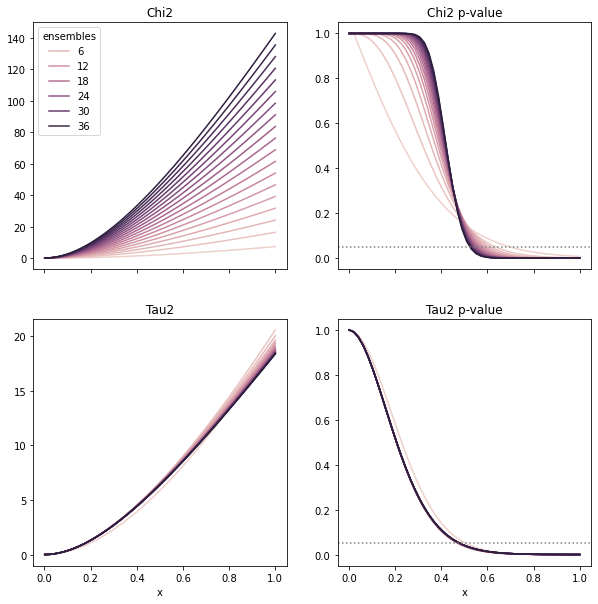

In [147]:
# Here i/N so that the total influence is normalised per ensemble
obs = 1000 # need to multiple by observations to compensate for above
# however, note this multiples by ensemble, so increased ensembles have more observations in total
compare(np.linspace(0.001,1.0,x_points), range(2,40,2), lambda x, h: np.array([[0.1,1+x*e/h] for e in range(h)])*obs, 'ensembles')

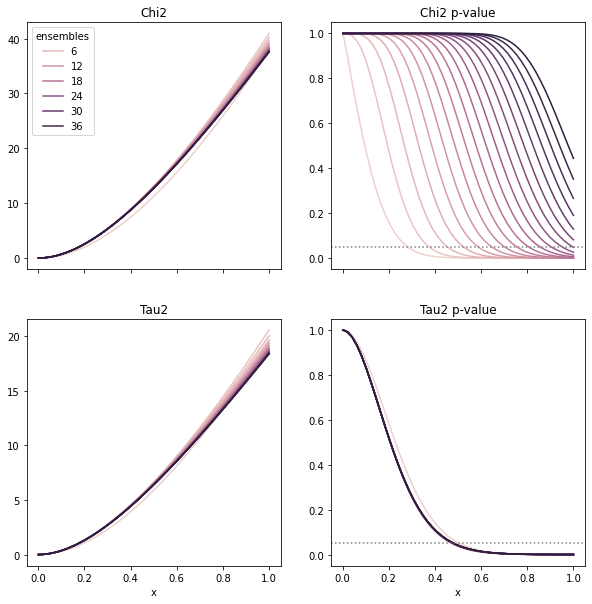

In [148]:
# Here i/N so that the total influence is normalised per ensemble as above
# however, now we also normalise the total number of observations by ensemble count
obs = 10000
compare(np.linspace(0.001,1.0,x_points), range(2,40,2), lambda x, h: np.array([[0.1,1+x*e/h] for e in range(h)])*obs/h, 'ensembles')

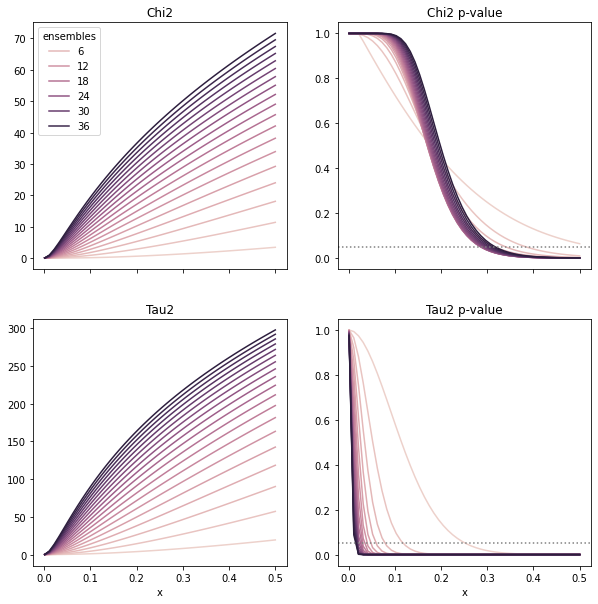

In [149]:
# Here it's just i, so the effect is amplified by the number of ensembles
obs = 1000 # but again normalising total obs
# Here we see that Chi2 doesn't reflect the increasing difference, with increasing ensembles as expected
compare(np.linspace(0.001,0.5,x_points), range(2,40,2), lambda x, h: np.array([[0.1,1+x*e] for e in range(h)])*obs/h, 'ensembles')

# States

### More states with a uniform difference
- increasing states makes the difference

In [150]:
obs = 1000
def state_hist_uniform(x, states):
    hists = [
        np.ones(states),
        np.concatenate([np.ones(int(states/2))*(1+x),np.ones(int(states/2))])]
    return np.array(hists)*obs/states

# normalised number of observations
# effectively taking a [p,q] state and splitting it into [p/2,p/2,q/2,q/2] etc
print(state_hist_uniform(0.5,2), state_hist_uniform(0.5,2).sum())
print(state_hist_uniform(0.5,4), state_hist_uniform(0.5,4).sum())

[[500. 500.]
 [750. 500.]] 2250.0
[[250. 250. 250. 250.]
 [375. 375. 250. 250.]] 2250.0


The fewer states you have, the higher the expected entropy of the variant distribution. Since this is an approximation. By definition the representation with these many states is the lowest possible (continous) entropy you have. Therefore the more states you have (although this is higher discrete entropy) it represents still the lower bound of possible entropy states.

Therefore the more states you have, the more confidence in the distribution you have. Therefore the lower complexity it should have. Therefore lower states should present as heterogenious faster than higher states.

Which is what we see with both models.

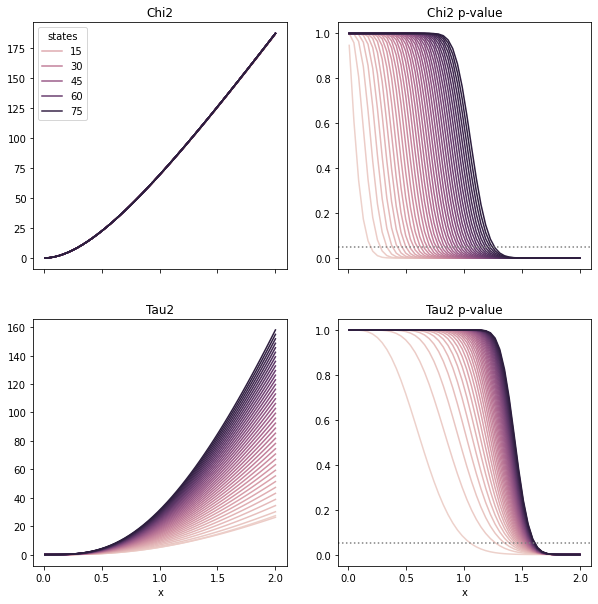

In [151]:
compare(np.linspace(0.01,2.0,x_points), range(2,80,2), state_hist_uniform, 'states')

- Here when we normalise for the number of observations, we see Chi2 doesn't actually care about the number of states (degrees of freedom) it cares about the number of observations, of which degree's of freedom is a proxy.

- Leading to here fewer states having a higher heterogenity, even though the absolute difference between these distributions is none.

- While Ce*states compensates for the number of states, so that once it's transformed to _p_ it still suffers from some difference, which disappears at the point of significance _p = 0.05_.

### More states with dimishing difference
- The fewer the states, the more significant the change
- C shows this as fewer states as being more heterogenious
- While _p_ does the same

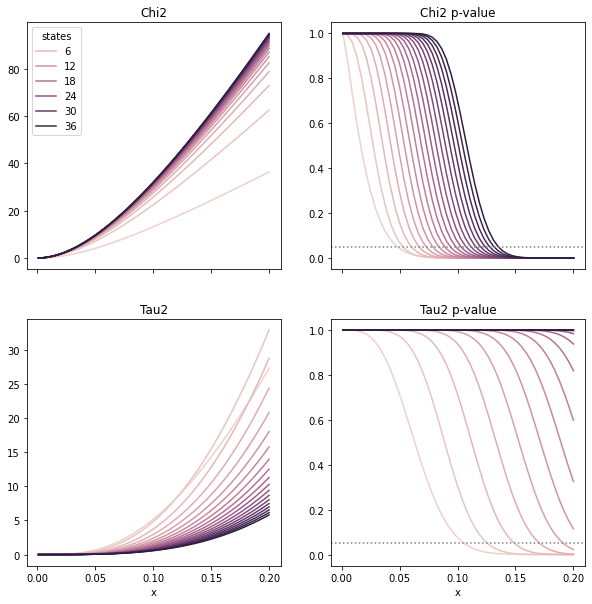

In [152]:
# Here it's designed so that the more states the smaller the difference in x
# Which is reflected in both, but more amplified with Ce
def state_hist(x, states):
    hists = np.array([np.ones(states)*0.1 for _ in range(2)])
    hists[1][1]+=x
    hists *= obs
    return hists

compare(np.linspace(0.001,0.2,x_points), range(2,40,2), state_hist, 'states')

# Checking that they are invariant to changes in state distribution

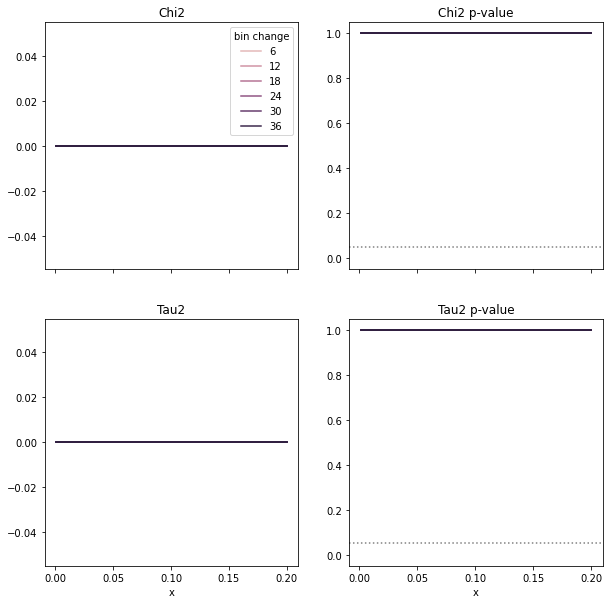

In [15]:
obs = 1000
compare(np.linspace(0.001,0.2,x_points), range(2,40,2), lambda x,h: np.array([[1+x*h,1],[1+x*h,1]])*obs, 'bin change')

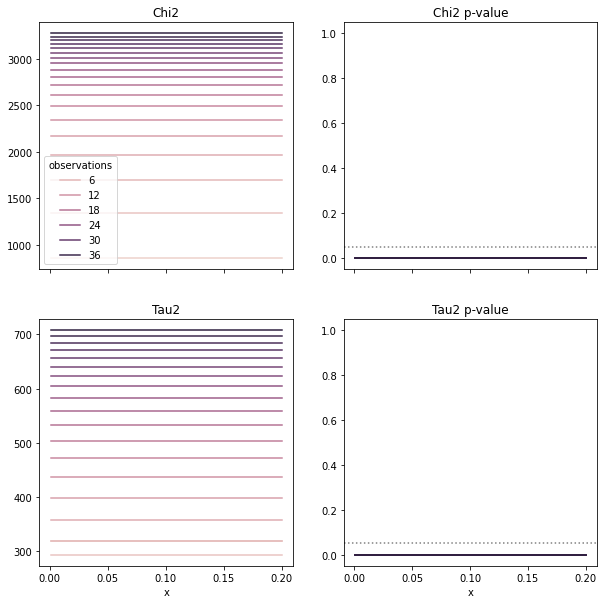

In [16]:
compare(np.linspace(0.001,0.2,x_points), range(2,40,2), lambda x,h: np.array([[0.1*h,1*h],[1,1]])*obs, 'observations')